In [2]:
#import libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# We will visualize the messages with a word cloud
from wordcloud import WordCloud
# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder
# Import the train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# I will keep the resulting plots
%matplotlib inline
# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

# Load the data
data = pd.read_excel('News.xlsx')

# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

[nltk_data] Downloading package stopwords to C:\Users\Özden
[nltk_data]     Özyurt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Özden
[nltk_data]     Özyurt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Özden
[nltk_data]     Özyurt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,NEWS,CATEGORY
0,How blood sugar levels may be connected to mig...,medicine
1,2 glaucoma drugs may prevent Alzheimer's-linke...,medicine
2,"Early diagnosis, treatment key to curbing cogn...",medicine
3,Strict blood pressure management may lower dem...,medicine
4,Consuming the following foods regularly may im...,medicine


,NEWS,CATEGORY
count,200,200
unique,189,2
top,Euro polls,medicine
freq,2,100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NEWS      200 non-null    object
 1   CATEGORY  200 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB
None


CATEGORY
medicine     100
technical    100
Name: count, dtype: int64

CATEGORY
medicine     0.5
technical    0.5
Name: proportion, dtype: float64


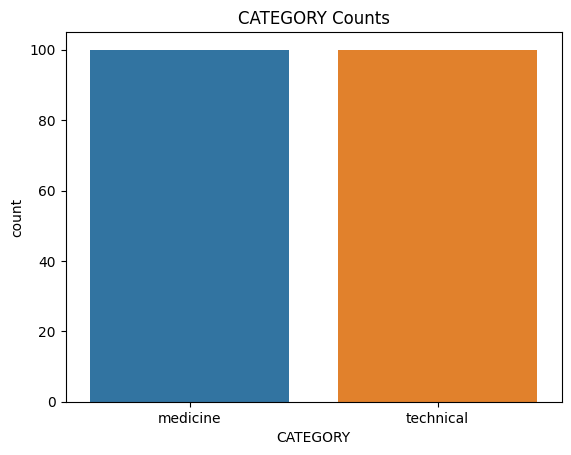

In [3]:
# Print the counts of each category
print(data['CATEGORY'].value_counts())

print()

# Print the proportions of each category
print(data['CATEGORY'].value_counts(normalize=True))

# Visualize the Categories
data['CATEGORY'] = data['CATEGORY'].astype('category')
sns.countplot(data=data, x='CATEGORY')
plt.title("CATEGORY Counts")
plt.show()

In [4]:
# Initialize the Label Encoder.
le = LabelEncoder()
# Encode the categories
data['Category_enc'] = le.fit_transform(data['CATEGORY'])
# Display the first five rows again to see the result
display(data.head())
# Print the datatypes
print(data.dtypes)

,NEWS,CATEGORY,Category_enc
0,How blood sugar levels may be connected to mig...,medicine,0
1,2 glaucoma drugs may prevent Alzheimer's-linke...,medicine,0
2,"Early diagnosis, treatment key to curbing cogn...",medicine,0
3,Strict blood pressure management may lower dem...,medicine,0
4,Consuming the following foods regularly may im...,medicine,0


NEWS              object
CATEGORY        category
Category_enc       int32
dtype: object


CATEGORY
medicine     21.35
technical    12.55
Name: word_count, dtype: float64


C:\Users\Özden Özyurt\AppData\Local\Temp\ipykernel_16924\3585295768.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['CATEGORY']=='medicine']['word_count'], label='medicine')
C:\Users\Özden Özyurt\AppData\Local\Temp\ipykernel_16924\3585295768.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s

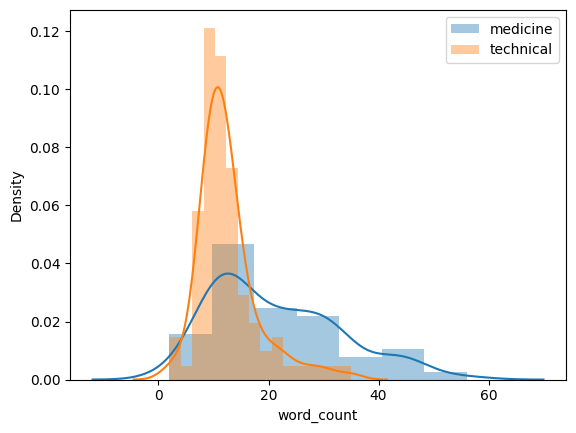

In [5]:
# Store the number of words in each messages
data['word_count'] = data['NEWS'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('CATEGORY')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['CATEGORY']=='medicine']['word_count'], label='medicine')
sns.distplot(data[data['CATEGORY']=='technical']['word_count'], label='technical'),
plt.legend()
plt.show()

In [6]:
# Make the letters lower case and tokenize the words
tokenized_messages = data['NEWS'].str.lower().apply(word_tokenize)
# Print the tokens to see how it looks like
print(tokenized_messages)

0      [how, blood, sugar, levels, may, be, connected...
1      [2, glaucoma, drugs, may, prevent, alzheimer's...
2      [early, diagnosis, ,, treatment, key, to, curb...
3      [strict, blood, pressure, management, may, low...
4      [consuming, the, following, foods, regularly, ...
                             ...                        
195    [opera, one, is, a, browser, designed, for, ge...
196    [samsung, 's, galaxy, watch, 5, is, cheaper, t...
197    [chromebooks, ', short, lifespans, are, creati...
198    [arm, is, reportedly, building, a, chip, to, s...
199    [apple, ’, s, mixed-reality, headset, may, com...
Name: NEWS, Length: 200, dtype: object


In [7]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(alpha)
print(tokenized_messages)

0      [how, blood, sugar, levels, may, be, connected...
1      [glaucoma, drugs, may, prevent, cognitive, imp...
2      [early, diagnosis, treatment, key, to, curbing...
3      [strict, blood, pressure, management, may, low...
4      [consuming, the, following, foods, regularly, ...
                             ...                        
195    [opera, one, is, a, browser, designed, for, ge...
196    [samsung, galaxy, watch, is, cheaper, than, ev...
197    [chromebooks, short, lifespans, are, creating,...
198    [arm, is, reportedly, building, a, chip, to, s...
199    [apple, s, headset, may, come, with, a, magnet...
Name: NEWS, Length: 200, dtype: object


In [8]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(remove_stop_words)
print(tokenized_messages)

0      [blood, sugar, levels, may, connected, migrain...
1      [glaucoma, drugs, may, prevent, cognitive, imp...
2      [early, diagnosis, treatment, key, curbing, co...
3      [strict, blood, pressure, management, may, low...
4      [consuming, following, foods, regularly, may, ...
                             ...                        
195    [opera, one, browser, designed, generative, ai...
196      [samsung, galaxy, watch, cheaper, ever, amazon]
197    [chromebooks, short, lifespans, creating, elec...
198     [arm, reportedly, building, chip, show, designs]
199    [apple, headset, may, come, magnetic, cable, e...
Name: NEWS, Length: 200, dtype: object


In [9]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(lemmatize)
print(tokenized_messages)

0      blood sugar level may connected migraine headache
1         glaucoma drug may prevent cognitive impairment
2      early diagnosis treatment key curbing cognitiv...
3      strict blood pressure management may lower dem...
4      consuming following food regularly may improve...
                             ...                        
195     opera one browser designed generative ai feature
196             samsung galaxy watch cheaper ever amazon
197    chromebooks short lifespan creating electronic...
198             arm reportedly building chip show design
199    apple headset may come magnetic cable external...
Name: NEWS, Length: 200, dtype: object


In [10]:
# Replace the columns with tokenized messages
data['NEWS'] = tokenized_messages
# Display the first five rows
display(data.head())

,NEWS,CATEGORY,Category_enc,word_count
0,blood sugar level may connected migraine headache,medicine,0,11
1,glaucoma drug may prevent cognitive impairment,medicine,0,8
2,early diagnosis treatment key curbing cognitiv...,medicine,0,10
3,strict blood pressure management may lower dem...,medicine,0,8
4,consuming following food regularly may improve...,medicine,0,27


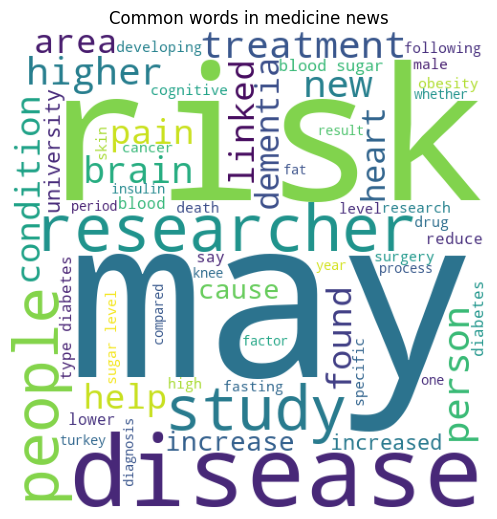

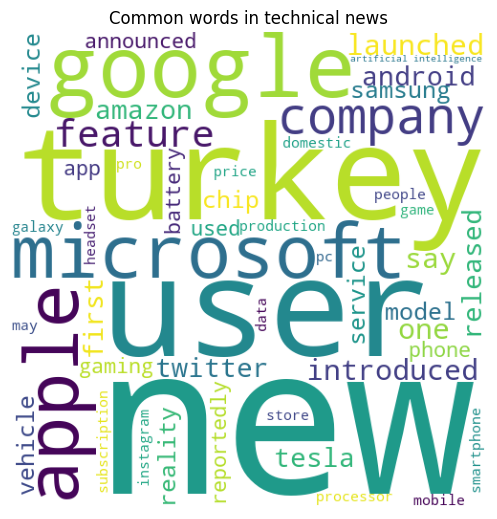

In [11]:
# Get the spam messages
medicine= data[data['CATEGORY']=='medicine']['NEWS'].str.cat(sep=', ')
# Get the ham messages
technical = data[data['CATEGORY']=='technical']['NEWS'].str.cat(sep=', ')
# Initialize the word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')
# Generate the world clouds for each type of message
medicine_wc = wc.generate(medicine)
# plot the world cloud for spam                     
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(medicine_wc) 
plt.axis("off") 
plt.title("Common words in medicine news")
plt.tight_layout(pad = 0) 
plt.show() 

technical_wc = wc.generate(technical)
# plot the world cloud for spam                       
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(technical_wc) 
plt.axis("off")
plt.title("Common words in technical news")
plt.tight_layout(pad = 0) 
plt.show() 

In [12]:
# Select the features and the target
X = data['NEWS']
y = data['CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=34, stratify=y)

# Create tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', ngram_range=(1, 2),stop_words='english', min_df=2, max_df=0.8, sublinear_tf=True)
# First fit the vectorizer with training set
tfidf_train = vectorizer.fit_transform(X_train)
# Fit test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=34, stratify=y)
# Create Gaussian Naive Bayes classifier
nb = GaussianNB()
# Fit the model
nb.fit(tfidf_train.toarray(), y_train)
# Print the accuracy score
print("Accuracy:", nb.score(tfidf_test.toarray(), y_test))


Accuracy: 0.85


Classification Report

              precision    recall  f1-score   support

    medicine       1.00      0.70      0.82        10
   technical       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



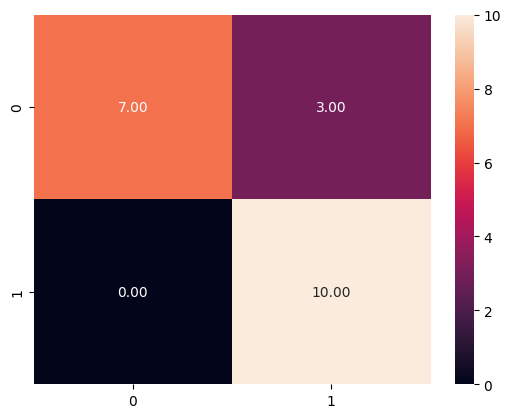

In [50]:
# Predict the labels
y_pred = nb.predict(tfidf_test.toarray())
# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = '.2f')
# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("Classification Report\n")
print(cr)

In [46]:
# To check class labels
categories = data['CATEGORY'].unique()
print(categories)


['medicine', 'technical']
Categories (2, object): ['medicine', 'technical']


In [14]:
from sklearn.preprocessing import LabelEncoder
# Convert real tags to numeric format
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
# Convert predictions to numerical format
y_pred_encoded = label_encoder.transform(y_pred)

from sklearn.metrics import roc_auc_score

# Calculate ROC AUC score
auc_score = roc_auc_score(y_test_encoded, y_pred_encoded)
print("\nROC AUC Score:", auc_score)




ROC AUC Score: 0.85


In [43]:
import random
# Pick a random sentence from the test dataset
test_sentence = random.choice(X_test)
# Create the TF-IDF vector of the sentence
test_vector = vectorizer.transform([test_sentence])
# Label prediction
predicted_label = nb.predict(test_vector.toarray())
# Print the prediction result to the screen
print("Prediction Result:", predicted_label)
print("Test Sentence:", test_sentence)

Prediction Result: ['medicine']
Test Sentence: darker skin tone eczema rash may appear gray purple pink red hue area skin may present darker surrounding area


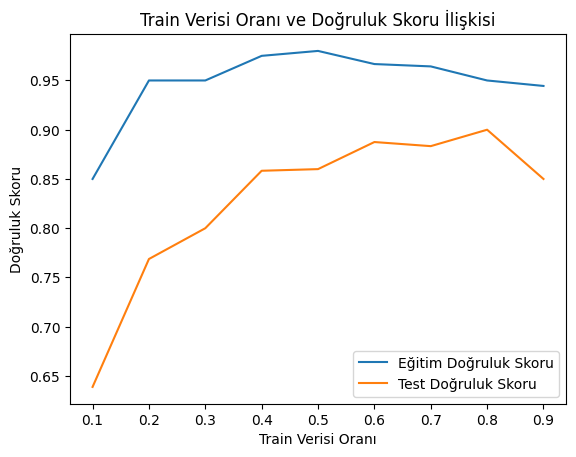

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Create a series to try different train data rates
train_sizes = np.linspace(0.1, 0.9, 9)

# Create an empty list, it will be used to store accuracy scores
accuracy_scores_train = []
accuracy_scores_test = []

# Train the model and record accuracy scores for each train data rate
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=34, stratify=y)
    
    tfidf_train = vectorizer.fit_transform(X_train)
    tfidf_test = vectorizer.transform(X_test)
    
    nb.fit(tfidf_train.toarray(), y_train)
    
    accuracy_train = nb.score(tfidf_train.toarray(), y_train)
    accuracy_test = nb.score(tfidf_test.toarray(), y_test)
    
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_test.append(accuracy_test)

# Create a graph with train and test data rates and accuracy scores
plt.plot(train_sizes, accuracy_scores_train, label='Eğitim Doğruluk Skoru')
plt.plot(train_sizes, accuracy_scores_test, label='Test Doğruluk Skoru')
plt.xlabel('Train Verisi Oranı')
plt.ylabel('Doğruluk Skoru')
plt.title('Train Verisi Oranı ve Doğruluk Skoru İlişkisi')
plt.legend()
plt.show()
